# 6. Gyakorlat: Aktor-Kritikus
## Könyvtárak

In [1]:
%pip install box2d-py

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gym
import random 
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import base64, io
from collections import deque
from collections import namedtuple

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

mpl.rc('animation', html='jshtml')

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings('ignore')

## Vizualizációs függvények

In [3]:
# Jeleneti változó beállítása
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

# Szekvenciális képkockák lejátszása egymás után
def plot_animation(frames, repeat=True, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Egy epizód lejátszása egy neurális hálózattal
def render_policy_net(agent, n_max_steps=500, seed=42, done_close=True, epsilon=0):
    env = gym.make('LunarLander-v2', render_mode='rgb_array')
    s = env.reset()[0]
    frames = []
    rewards = []
    for step in range(n_max_steps):
        frames.append(env.render())   
        a, entropy = agent.act(s)
        sp, r, done, info, _ = env.step(a) # Execute step
        rewards.append(r)
        s = sp

        if done_close and done:
            break

    env.close()
    return frames, rewards

# Jutalmak ábrázolása
def plot_rewards(rewards, episode=True):
    n = len(rewards)
    if(episode):
        df = pd.DataFrame({'Rewards': rewards, 'Step': np.arange(n)})
        sns.lineplot(data=df, x='Step', y='Rewards').set(title="Jutalom "+str(n)+" lépés alatt:")
    else:
        df = pd.DataFrame({'Rewards': rewards, 'Epoch': np.arange(n)})
        sns.lineplot(data=df, x='Epoch', y='Rewards').set(title="Jutalom "+str(n)+" epizód alatt")

---
## $Q$-hálózat

In [4]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size): # Define the architecture
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        
        # Kritikus fej: visszaatéríti a V(s) állapot értéket
        self.critic_head = nn.Linear(64, 1)

        # Aktor fej: visszatéríti a Q(s,a) cselekvés értéket
        self.actor_head = nn.Linear(64, action_size)
        
    def forward(self, state):  # Előrecsatolás a rétegeken
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)

        # Milyen jó a jelenlegi állapot?
        state_value = self.critic_head(x)

        # Cselekvések megtételének valószínűség eloszlása
        policy_dist = F.softmax(self.actor_head(x), dim=-1)

        return state_value, policy_dist

---
## Ügynök

In [5]:
class Agent():
    def __init__(self, state_size, action_size, alpha, gamma):
        # Paraméterek
        self.alpha = alpha
        self.gamma = gamma
        self.state_size = state_size
        self.action_size = action_size
        self.model_name = 'checkpoint_AC.pth'
        # Környezet és optimalizáló
        self.qnetwork = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr = alpha) 
        # Követési struktúrák
        self.Vs = []
        self.rewards = []
        self.log_probs = []
    
    def act(self, s):
        V, policy_dist = self.qnetwork.forward(s)
        V = V.detach().numpy()[0, 0]
        policy_dist_np = policy_dist.detach().numpy()
        a = np.random.choice(self.action_size, p = np.squeeze(policy_dist_np))

        log_prob = torch.log(policy_dist.squeeze(0)[a])
        entropy = -np.sum(np.mean(policy_dist_np) * np.log(policy_dist_np))

        self.Vs.append(V)
        self.log_probs.append(log_prob)

        return a, entropy

    def learn(self, Q, entropy_term):
        # Q-értékek kiszámítása
        Qs = np.zeros_like(self.Vs)
        for t in reversed(range(len(self.rewards))):
            Q = self.rewards[t] + self.gamma * Q
            Qs[t] = Q
        
        # Aktor-kritikus frissítése
        V = torch.FloatTensor(self.Vs)
        Qs = torch.FloatTensor(Qs)
        log_probs = torch.stack(self.log_probs)

        advantage = Qs - V  # Előnyfüggvény kiszámítása
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()

        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        self.optimizer.zero_grad()  # Gradiensek 0-ra állítása
        ac_loss.backward()  # Gradiensek visszacsatolása a hálózatba
        self.optimizer.step()  # Lépés végrehajtása az optimalizálóval

    def forget(self):  # Változók visszaállítása az eredetibe
        self.Vs = []
        self.rewards = []
        self.log_probs = []

    def save_model(self):
        torch.save(self.qnetwork.state_dict(), self.model_name)  # Modell mentése

---
## Tanítás

In [6]:
max_t = 1000  # Max. időlépés egy epizódon belül
gamma = 0.99  # Diszkont ráta
alpha = 5e-4  # Tanulási sebesség 
batch_size = 64  # Kötegméret
n_episodes = 12000  # Epizódok száma
entropy_term = 0

scores = []  # Jutalmak követése
scores_window = deque(maxlen=100)  # Utolsó 100 iteráció követése

env = gym.make('LunarLander-v2')
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

agent = Agent(state_size = state_size, 
              action_size = action_size, 
              alpha = alpha, 
              gamma = gamma)

print('Környezeti változó: ', env.observation_space.shape)
print('Cselekvések száma: ', env.action_space.n)

Környezeti változó:  (8,)
Cselekvések száma:  4


In [7]:
for i in range(n_episodes):
    agent.forget()
    s = np.array(env.reset()[0])
    r_sum = 0
    for steps in range(max_t):
        a, entropy = agent.act(s)
        sp, r, done, info, _ = env.step(a)
        sp = np.array(sp)
        agent.rewards.append(r)
        entropy_term += entropy
        r_sum += r
        s = sp

        if done or steps == max_t-1:
            Q, _ = agent.qnetwork.forward(sp)
            Q = Q.detach().numpy()[0,0]
            break
    
    agent.learn(Q, entropy_term=entropy_term)
    scores_window.append(r_sum)  # Jutalom hozzáadása az ablakos kumulált jutalomhoz
    scores.append(r_sum)  # Jutalom hozzáadása a kumulált jutalomhoz

    if i % 200 == 0:  # Minden 200 epizódban információ a tanulásól
        print(f'Epizód: {i}, Átlagos jutalom: {np.mean(scores_window)}')

    if np.mean(scores_window) >= 200:  # A feladat megoldottnak tekinthető ha a jutalom 200 felett van
        print(f'Környezet megolva {i} epizód alatt')
        print(f'Átlagos jutalom: {np.mean(scores_window)}')
        agent.save_model()
        print('Modellek mentése sikeres')
        break

Epizód: 0, Átlagos jutalom: -460.05246596736794
Epizód: 200, Átlagos jutalom: -164.20147808264448
Epizód: 400, Átlagos jutalom: -157.5653731555815
Epizód: 600, Átlagos jutalom: -142.84457821581057
Epizód: 800, Átlagos jutalom: -147.94458950004176
Epizód: 1000, Átlagos jutalom: -119.97490508585257
Epizód: 1200, Átlagos jutalom: -124.45234667220372
Epizód: 1400, Átlagos jutalom: -96.91801998396589
Epizód: 1600, Átlagos jutalom: -135.23918715805118
Epizód: 1800, Átlagos jutalom: -108.40226403494482
Epizód: 2000, Átlagos jutalom: -76.00810519437847
Epizód: 2200, Átlagos jutalom: -61.63947566395469
Epizód: 2400, Átlagos jutalom: -24.778077956692474
Epizód: 2600, Átlagos jutalom: -18.76877358000737
Epizód: 2800, Átlagos jutalom: -37.739171152912874
Epizód: 3000, Átlagos jutalom: -24.646051801713707
Epizód: 3200, Átlagos jutalom: -15.873470147408081
Epizód: 3400, Átlagos jutalom: -23.077378063222195
Epizód: 3600, Átlagos jutalom: -6.7799800727792965
Epizód: 3800, Átlagos jutalom: 12.729428144

In [8]:
np.array(env.reset()[0])

array([ 0.00565519,  1.4216442 ,  0.5728033 ,  0.47660688, -0.00654624,
       -0.12974854,  0.        ,  0.        ], dtype=float32)

---
### Kiértékelés
#### Jutalmak ábrázolása

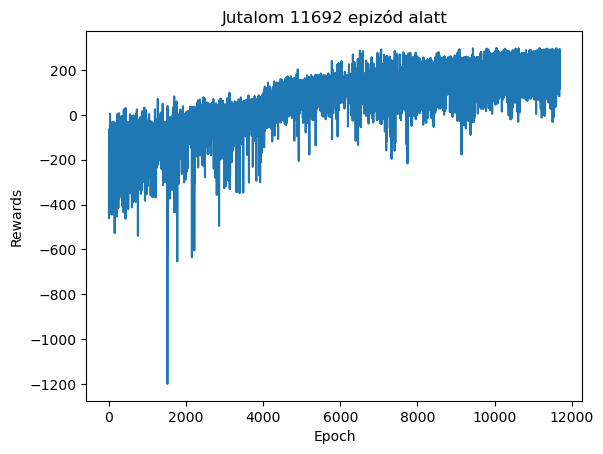

In [9]:
plot_rewards(scores, episode=False)

#### Átlagos jutalmak

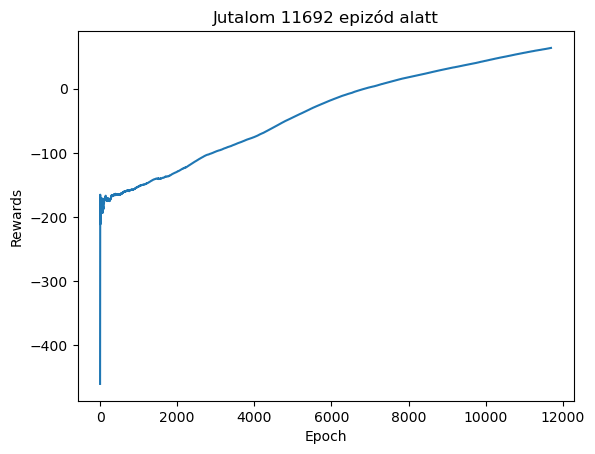

In [10]:
avg_rew_calc = lambda x: [np.mean(x[:i+1]) for i in range(len(x))]
average_rewards = avg_rew_calc(scores)

plot_rewards(average_rewards, episode=False)

#### Egy epizód animálása

In [11]:
frames, rewards = render_policy_net(agent)
plot_animation(frames)